In [67]:
import numpy as np


from watermatrices import Amat, Bmat, yvec

In [68]:
size = Amat.shape[0]

E = np.block([[Amat, Bmat],
              [Bmat, Amat]])

S = np.block([[np.eye(size),           np.zeros((size,size))], 
              [np.zeros((size,size)), -np.eye(size)]])

z = np.hstack([yvec,-yvec])


data = {"E" : E, "S" : S, "z" : z}


In [112]:
# maxnorm is the maximum absolute row sum of the matrix.

maxnorm = lambda M: np.abs(M).sum(axis=1).max()

condition_number = lambda M: maxnorm(M) * maxnorm(np.linalg.inv(M))

In [122]:
ws = [0.800, 1.146, 1.400]

for w in ws:
    print("ω = ", w)
    print("Condition number of E - ωS: ", condition_number(E-w*S))

ω =  0.8
Condition number of E - ωS:  327.81670424209915
ω =  1.146
Condition number of E - ωS:  152679.2687523386
ω =  1.4
Condition number of E - ωS:  227.19443667104446


Error

In [213]:
sigfigs = lambda y,dy: -np.log10(np.abs(dy / y))
sigfigs2 = lambda y,dy: np.log10(np.abs(y))-np.log10(np.abs(dy))

In [116]:
for w in ws:
    print(int(8-np.log10(condition_number(E-w*S))))

5
2
5


In [134]:
dw = 1e-3

b_bound = lambda w, dw: condition_number(data["E"]-w*data["S"])*maxnorm(dw*data["S"])/maxnorm(data["E"]-w*data["S"])

for w in ws:
    bound = b_bound(w, dw)


    print("ω = ", w)
    print(f"Bound {bound:.4}")

ω =  0.8
Bound 0.01044
ω =  1.146
Bound 4.81
ω =  1.4
Bound 0.007101


# LU Decomp

In [132]:
# this is going to be useful later
def same(a,b):
    return np.isclose(a,b).all()

def lu_factorize(M, should_pivot=True):
    assert M.shape[0] == M.shape[1], "Matrix should be square"

    # helper function for generating identity matrix
    I = lambda: np.eye(M.shape[0]).astype(float)

    # I am very scared of numpy-stuff being mutable :(
    U = M.copy()

    # get ready for generating L (needed when pivoting)
    Ls = np.empty((M.shape[0]-1,*M.shape))
    Ps = np.empty((M.shape[0]-1,*M.shape))
    
    for i in range(M.shape[0]-1):
        # pivot
        P = I()
        if should_pivot:
        # find best row
            best = np.argmax(U[i:,i]) + i # compensate for looking at submatrix

            # swap
            P[[i,best]] = P[[best,i]]

            # apply
            U = P@U

        # save for generating L
        Ps[i] = P

        # eliminate
        coeff = I()

        # find coefficients
        cc = -U[(i+1):,i]/U[i,i]
        coeff[(i+1):,i] = cc

        # apply
        U = coeff@U

        # save for generating L
        coeff[(i+1):,i] = -cc
        Ls[i] = coeff
    
    # generate L
    L = I()
    for ii in range(len(Ps))[::-1]:
        L = Ls[ii]@L
        L = Ps[ii].T@L


    assert same(L@U, M), "Decomposition did not work"

    return U, L



# M = np.array([1, 2, 2, 4, 4, 2, 4, 6, 4], dtype=float)
# M = M.reshape((3,3))
# z = [3,6,10]

M = np.array([2, 1, 1, 4, 1, 4, -6, -5, 3], dtype=float)
M = M.reshape((3,3))
z = [4, 11, 4]

print("M")
print(M, end= "\n\n")
    
d = lu_factorize(M, should_pivot=False)
print(*d,sep="\n")


M
[[ 2.  1.  1.]
 [ 4.  1.  4.]
 [-6. -5.  3.]]

[[ 2.  1.  1.]
 [ 0. -1.  2.]
 [ 0.  0.  2.]]
[[ 1.  0.  0.]
 [ 2.  1.  0.]
 [-3.  2.  1.]]


In [133]:
def forward_substitute(L, z):
    y = np.empty_like(z)

    for k in range(L.shape[0]):
        y[k] = z[k] - np.dot(L[k, 0:k], y[0:k])

    return y


def backward_substitute(U, y):
    x = np.empty_like(y)
    N = U.shape[0]
    for k in range(N)[::-1]:
        x[k] = (y[k] - np.dot(U[k, (k+1):N], x[(k+1):N])) / U[k,k]
    return x


def solve(M, z):
    U, L = lu_factorize(M, should_pivot=False)
    y = forward_substitute(L, z)
    x = backward_substitute(U, y)
    assert same(x, np.linalg.solve(M,z)), "Numpy says solution is wrong"
    assert same(M@x, z), "x is not a solution"
    return x



# M = np.array([2, 1, 1, 4, 1, 4, -6, -5, 3], dtype=float)
M = np.array([2, 1, 1, 4, 1, 4, -6, -5, 3], dtype=float)

M = M.reshape((3,3))
z = [4, 11, 4]


solve(M,z)


array([-4,  7,  5])

In [127]:
def solve_alpha(omega):
    M = data["E"]-omega*data["S"]

    x = solve(M, data["z"])
    
    alpha = (data["z"]*x).sum()
    return alpha

In [142]:

ws = [0.800, 1.146, 1.400]
dw = 0.5e-3
# ws = [0.246]
# dw = 0



for w in ws:
    for d in [-dw, dw]:
        sol = solve_alpha(w + d)
        
        print( w,("+" if d > 0 else "") + str(d))
        print(sol)
        bound = b_bound(w, dw)
        print("bound", bound)


0.8 -0.0005
1.6278156988765353
bound 0.005220745069573262
0.8 +0.0005
1.6444312026849457
bound 0.005220745069573262
1.146 -0.0005
994.752991630176
bound 2.4050352674535698
1.146 +0.0005
-4185.018283381866
bound 2.4050352674535698
1.4 -0.0005
-2.7138801135166397
bound 0.0035504027789308675
1.4 +0.0005
-2.699926805997851
bound 0.0035504027789308675


In [76]:
import matplotlib.pyplot as plt


[-178064759.54153937,
 -182689451.38363755,
 -187300488.98059678,
 -191897831.1443278,
 -196481436.7723614,
 -201051264.8482793,
 -205607274.4421448,
 -210149424.7109374,
 -214677674.89897817,
 -219191984.33837092,
 -223692312.44942558,
 -228178618.74109808,
 -232650862.81142327,
 -237109004.34794208,
 -241553003.1281461,
 -245982819.0199046,
 -250398411.98189947,
 -254799742.06406328,
 -259186769.40801716,
 -263559454.2474979,
 -267917756.90880275,
 -272261637.8112236,
 -276591057.46748346,
 -280905976.4841699,
 -285206355.56218195,
 -289492155.49715954,
 -293763337.17992514,
 -298019861.5969235,
 -302261689.83065915,
 -306488783.0601385,
 -310701102.5613,
 -314898609.7074716,
 -319081265.9697952,
 -323249032.9176739,
 -327401872.2192179,
 -331539745.6416729,
 -335662615.05187804,
 -339770442.4166971,
 -343863189.8034607,
 -347940819.38041675,
 -352003293.4171693,
 -356050574.28512096,
 -360082624.457918,
 -364099406.51189965,
 -368100883.1265308,
 -372087017.08485824,
 -376057771.273

C:\Users\jakob\AppData\Local\Temp\ipykernel_2876\4209056054.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


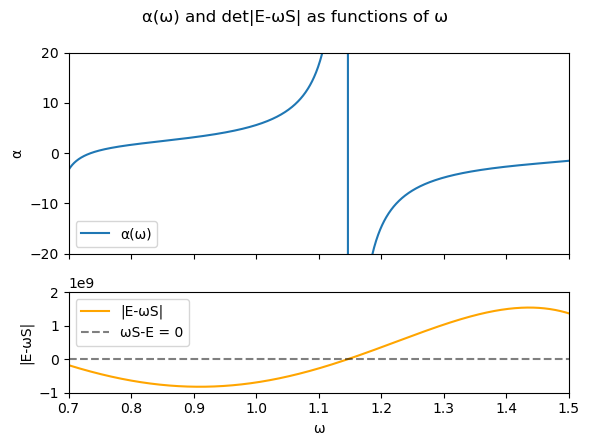

In [189]:
w_table = np.linspace(0.7, 1.5, 1000, endpoint=True)

alpha_table = np.array([solve_alpha(w) for w in w_table])



# plt.vlines(w_interesting, -1e3, 1e3,"red", '--')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,4.5), gridspec_kw={'height_ratios': [2, 1]}, constrained_layout=True)
axs[0].plot(w_table, alpha_table, label = "α(ω)")
axs[1].plot(w_table, [np.linalg.det(data["E"]-w*data["S"]) for w in w_table], label = "|E-ωS|", color="orange")
axs[0].set_ylim(-20,20)
axs[1].set_ylim(-1e9,2e9)
plt.xlim(0.7,1.5)
axs[1].hlines(0, 0.7, 1.5, "black", '--', alpha=0.5, label = "ωS-E = 0")
axs[0].set_ylabel("α")
axs[1].set_ylabel("|E-ωS|")
axs[1].set_xlabel("ω")
fig.suptitle("α(ω) and det|E-ωS| as functions of ω")
axs[0].legend(loc="lower left")
axs[1].legend(loc="upper left")
plt.tight_layout()
plt.show()

householder

In [78]:
test = np.arange(0, 9, 1).reshape((3,3))

print(test)
# loop over columns
for i in range(test.shape[1]):
    # print the column
    print(test[:,i])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 3 6]
[1 4 7]
[2 5 8]


In [79]:
# def norm(x):
#     n = np.sqrt((x*x).sum())
#     assert np.isclose(n, np.linalg.norm(x)), "Norm is wrong"
#     return n
from numpy.linalg import norm

def householder_QR_slow(A):
    m = A.shape[0]

    # helper function for generating identity matrix
    I = lambda: np.eye(m).astype(float)

    # Initialize Q and R
    Q = I()
    R = A.copy()

    for k in range(min(A.shape)):

        # Need to zero out the lower part of the k'th column to get in the right shape
        vk = np.zeros(m)

        # copy the lower part of the k'th column
        vk[k:] = R[k:, k].copy()

        # subtract "a_k" in the k'th column
        vk[k] -= -np.sign(vk[k]) * norm(vk)  

        # we dont want to divide by zero
        beta = np.dot(vk, vk)
        if beta == 0:
            continue

        # make the transformation matrix
        H = I() - 2 * np.outer(vk, vk) / beta

        # apply it
        R = H @ R
        Q = H @ Q

    # As can be seen on side 124, we are actually constructing Q^T
    Q = Q.T

    # check that we did it right, as asked
    assert same(Q.T @ Q, np.eye(m)), "Q is not orthogonal"
    assert same(Q@R, A), "QR is wrong"
    
    return Q, R

# B = np.array([[2,-2,18],[2,1,0],[1,2,0]]).astype(float)
example_31 = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,1,0],[-1,0,1],[0,-1, 1]]).astype(float)

Q, R = householder_QR_slow(example_31)

print("Q@R = A?")
print(same(Q@R, example_31))


Q@R = A?
True


In [80]:

def householder_fast(A):
    # a lot of this is copied from the slow version
    m, n = A.shape
    I = lambda: np.eye(m).astype(float)

    # initialize R and V
    R = A.copy()
    V = np.zeros(( A.shape[0]+1, A.shape[1])).T # transposing for easier indexing later

    for k in range(min(A.shape)):
        # Need to zero out the lower part of the k'th column to get in the right shape
        vk = np.zeros(m)

        # copy the lower part of the k'th column
        vk[k:] = R[k:, k].copy()

        # subtract "a_k" in the k'th column
        vk[k] -= -np.sign(vk[k]) * norm(vk)    # fortegnsfejl i bogen?

        beta = np.dot(vk, vk)
        
        if beta == 0:
            continue

        # make the transformation matrix
        H = I() - 2 * np.outer(vk, vk) / beta
        
        # apply it, but only to R
        R = H@R

        # save vk (this works because of the transposing earlier)
        V[k,1:] = vk
    
    # re-transpose (is that a word?)
    V = V.T

    # make R same shape as V
    R = np.vstack((R, np.zeros_like(R[0])))
    
    # add V and R for the final result
    VR = V + R
    
    assert same(np.linalg.qr(A)[1], R[:min(A.shape),:min(A.shape)]), "R is wrong"

    return VR


VR = householder_fast(example_31)

print(VR, end="\n\n")

# import time 
# start = time.time()
# for i in range(10000):
#     _ = householder_fast(example_31)
# print(time.time() - start)
# start = time.time()
# for i in range(10000):
#     _ = householder_QR_slow(example_31)
# print(time.time() - start)

[[-1.73205081e+00  5.77350269e-01  5.77350269e-01]
 [ 2.73205081e+00 -1.63299316e+00  8.16496581e-01]
 [-6.79869978e-17  2.63299316e+00 -1.41421356e+00]
 [ 9.83286241e-17 -5.72291037e-17  2.41421356e+00]
 [-1.00000000e+00  7.88675135e-01  3.32449118e-02]
 [-1.00000000e+00 -2.11324865e-01  7.23142860e-01]
 [ 0.00000000e+00 -1.00000000e+00  6.89897949e-01]]



In [197]:
example_31 = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,1,0],[-1,0,1],[0,-1,1]]).astype(float)

b_31 = np.array([1237, 1941, 2417, 711, 1177, 475]).astype(float)
x_31 = [1236, 1943, 2416]

def solve_least_squares(A, b, print_upper = False):
    # find V an R
    VR = householder_fast(A.copy())
    R1 = np.triu(VR)[:A.shape[1],:]
    vs = np.tril(VR, -1)[1:,:]
    if print_upper:
        print("R1")
        print(R1)

    # we dont want to modify b
    c = b.copy()


    # We can simply use the vectors (no need for using a matrix)
    for v in vs.T:
        c -= 2 * v * np.dot(v,c)/np.dot(v,v)

    # solve R1x = c1 as described in the book
    c1 = c[:R1.shape[1]]
    x = backward_substitute(R1, c1)
    
    assert same(x, np.linalg.lstsq(A,b, rcond = None)[0]), "Numpy says solution is wrong"
    return x

sol = solve_least_squares(example_31, b_31)

print(sol, "\nIs right?:", same(sol, x_31))


[1236. 1943. 2416.] 
Is right?: True


In [198]:
from HHexamples import A1, b1, x1

sol = solve_least_squares(A1, b1.astype(float), print_upper=True)

print("Correct?",same(sol, x1))

print(f"{sol[0]:.3f} and {sol[1]:.3f}")

R1
[[-5.91607978 -7.43735744]
 [ 0.          0.82807867]]
Correct? True
-0.000 and 0.500


Polyfit

Vandermonde matrix

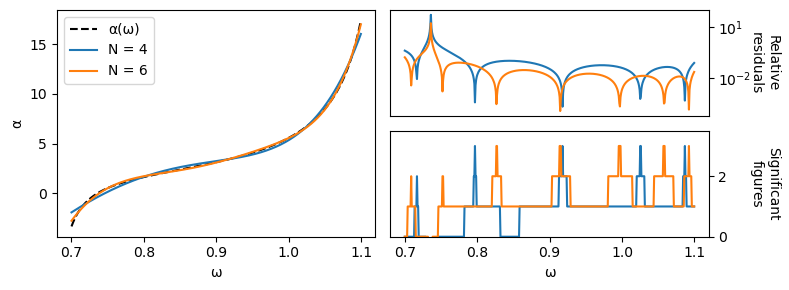

In [298]:
# x_range = np.linspace(0.7, 1.5, 1000)
vandermonde_1 = lambda ws, N: np.array([[w**(2*i) for i in range(N+1)] for w in ws])

mask = w_table < 1.1


# fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6,4.5), gridspec_kw={'height_ratios': [1,1,1]}, constrained_layout=True)
fig = plt.figure(figsize=(8, 3))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(2, 2, 2,)
ax2 = fig.add_subplot(2, 2, 4,)
# ax1.get_shared_x_axes().join(ax1, ax2)

axs = [ax0, ax1, ax2]
# make three uneven suplots, one big to the left and two small to the right

axs[0].plot(w_table[mask], alpha_table[mask], '--',label = "α(ω)", color="black")
for N in [4,6]:
    vm = vandermonde_1(w_table[mask], N)

    sol = solve_least_squares(vm, alpha_table[mask])
    sol = np.dot(vm, sol)
    axs[0].plot(w_table[mask], sol, label=f"N = {N}")

    residual = np.array(sol - alpha_table[mask])

    relative_residual = np.abs(residual) / np.abs(alpha_table[mask])
    
    axs[1].plot(w_table[mask], relative_residual, label=f"N = {N}")

    sigf = np.floor(sigfigs(alpha_table[mask], residual))
    axs[2].plot(w_table[mask], sigf, label=f"N = {N}")

axs[1].set_yscale("log")
axs[2].set_ylim(0, 3.5)
axs[0].legend()
axs[0].set_ylabel("α")

axs[1].set_ylabel("Relative\nresiduals", rotation=270, labelpad=20)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].set_ylabel("Significant\nfigures", rotation=270, labelpad=38)
axs[2].yaxis.set_label_position("right")
axs[2].yaxis.tick_right()

axs[1].set_xticks([])
axs[0].set_xlabel("ω")
axs[2].set_xlabel("ω")

fig.tight_layout()
plt.show()

![Alt text](image.png)

In [283]:
N = 2

def get_vandermonde_2(ws, N):
    alphas = -np.array([solve_alpha(w) for w in ws])
    vandermonde_2 = np.array([[w**(i) for i in range(1,N+1)] for w in ws])
    vandermonde_2 = np.concatenate((np.ones(vandermonde_2.shape[0])[:,np.newaxis],vandermonde_2, (alphas * vandermonde_2.T).T), axis=1)
    return vandermonde_2


def get_single_vandermonde(ws, N, start_from = 0):
    return np.array([[w**i for i in range(start_from,N+1)] for w in ws])


# np.append(, vandermonde_2

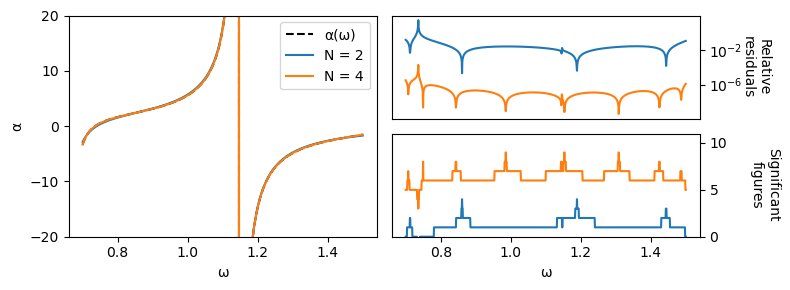

In [297]:
# x_range = np.linspace(0.7, 1.5, 1000)
# vandermonde_2 = lambda ws, N: np.array([[w**(i) for i in range(N)] + [-get_a w**(i) for i in range(N)]  for w in ws])


# np.tile()


# mask = w_table < w_interesting-0.2

fig = plt.figure(figsize=(8, 3))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(2, 2, 2,)
ax2 = fig.add_subplot(2, 2, 4,)
# ax1.get_shared_x_axes().join(ax1, ax2)
axs = [ax0, ax1, ax2]

axs[0].plot(w_table, alpha_table, '--',label = "α(ω)", color="black")

for N in [2, 4]:
    vm = get_vandermonde_2(w_table, N)

    sol = solve_least_squares(vm, alpha_table)

    a = sol[:N+1]
    b = sol[N+1:]

    single_vandermonde = get_single_vandermonde(w_table, N)

    sol_a = np.dot(single_vandermonde, a)
    sol_b = np.dot(single_vandermonde[:,1:], b)
    final_sol = sol_a/(1 + sol_b)
    # final_sol = sol_a - sol_b
    residual = final_sol - alpha_table

    relative_residual = np.abs(residual) / np.abs(alpha_table)
    sigf = np.floor(sigfigs(alpha_table, residual))

    axs[0].plot(w_table, final_sol, label=f"N = {N}")
    axs[1].plot(w_table, relative_residual, label=f"N = {N}")
    axs[2].plot(w_table, sigf, label=f"N = {N}")



axs[1].set_yscale("log")

axs[0].set_ylim(-20,20)
axs[2].set_ylim(0, 11)

axs[0].legend()
axs[0].set_ylabel("α")

axs[1].set_ylabel("Relative\nresiduals", rotation=270, labelpad=20)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].set_ylabel("Significant\nfigures", rotation=270, labelpad=38)
axs[2].yaxis.set_label_position("right")
axs[2].yaxis.tick_right()

axs[1].set_xticks([])
axs[0].set_xlabel("ω")
axs[2].set_xlabel("ω")

fig.tight_layout()
plt.show()